### (OPTIONAL)

Compare the accuracy/ROC with those achieved by the MLP classifier that predicts the label using the **mean of the word embeddings** (without junk tokens). Consider a three layer MLP with 10 and 5 hidden units respectively.


<img src='http://www.tsc.uc3m.es/~olmos/BBVA/MLP.png' width=800 />

Note: for this part, we have recycled just the necessary code from previous part.

In [1]:
# To use it in colab, update spacy
#!pip install --upgrade spacy

In [2]:
# Download language model

!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 22.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [18]:
import numpy as np
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

# Loading data

In [21]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]


def code_opinion(l):

    d = 0

    if (l=='negative\n'):

        d = 1

    elif (l=='positive\n'):

        d = 2

    return d

labels = np.array([code_opinion(l) for l in opinions])


df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})

labels_bin = labels.copy()

labels_bin[labels_bin==2] = 0

idx_data = np.arange(0,len(df),1)

# Separamos train de test
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)

acc_baseline_train = np.sum(y_train==0)/y_train.shape[0]

In [22]:
nlp = spacy.load("en_core_web_md") # Language model


docs = [nlp(c) for c in phrases]

# We remove punctuation marks (.,;:?!...) and stopping words
def normalize(doc):

    return [w for w in doc if w.has_vector and not w.is_punct and not w.is_stop]

norm_docs = [normalize(d) for d in docs]

# List with the length for each sentence

lengths = [len(d) for d in norm_docs]

# Maximum length (in train!)
max_l = np.max([lengths[d] for d in idx_train])



In [23]:
# No adding '#' for padding
docs_train = [norm_docs[d] for d in idx_train]
len_train = [len(doc) for doc in docs_train]

docs_val = [norm_docs[d] for d in idx_val]
len_val = [len(doc) for doc in docs_val]

docs_test = [norm_docs[d] for d in idx_test]
len_test = [len(doc) for doc in docs_test]


#Building classifier MLP

In [24]:

# MLP Classifier

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden1=10, hidden2=5, output_dim=2):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [25]:
def create_input_data(docs, lengths):
    averaged_docs = []
    for i in range(len(docs)):
        if lengths[i] > 0:  # Ensure the document is not empty
            doc_vectors = [w.vector for w in docs[i][:lengths[i]]]
            averaged_doc = np.mean(doc_vectors, axis=0)
        else:
            averaged_doc = np.zeros(300)  # Size of the word vectors
        averaged_docs.append(torch.tensor(averaged_doc, dtype=torch.float32))
    return torch.stack(averaged_docs)  # Stack to create a single tensor



# Train the model

In [26]:
# Instantiate the MLP and Train
mlp_model = MLPClassifier(input_dim=300, hidden1=10, hidden2=5, output_dim=2)
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Prepare data
train_data = create_input_data(docs_train, len_train)
val_data = create_input_data(docs_val, len_val)
test_data = create_input_data(docs_test, len_test)

# Similar training loop as in RNN
def train_model(model, train_data, val_data, train_labels, val_labels, epochs=40):
    train_labels = torch.Tensor(train_labels).type(torch.LongTensor)
    val_labels = torch.Tensor(val_labels).type(torch.LongTensor)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_data)
        loss = criterion(output, train_labels)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_output = model(val_data)
            val_loss = criterion(val_output, val_labels)
        if epoch % 5 == 0:
            print(f'Epoch {epoch}: Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

train_model(mlp_model, train_data, val_data, y_train, y_val)




Epoch 0: Train Loss: 0.6407817006111145, Val Loss: 0.6347354650497437
Epoch 5: Train Loss: 0.6242298483848572, Val Loss: 0.618457019329071
Epoch 10: Train Loss: 0.6089347004890442, Val Loss: 0.6018706560134888
Epoch 15: Train Loss: 0.5911007523536682, Val Loss: 0.5829300284385681
Epoch 20: Train Loss: 0.5719090104103088, Val Loss: 0.5623571276664734
Epoch 25: Train Loss: 0.5512763857841492, Val Loss: 0.5407242774963379
Epoch 30: Train Loss: 0.5303922295570374, Val Loss: 0.5185146927833557
Epoch 35: Train Loss: 0.5097309947013855, Val Loss: 0.4960702359676361


# Compute acc and ROC curve

In [27]:
def calculate_accuracy(model, data, labels):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        accuracy = correct / total
    return accuracy

# Calculate test accuracy
test_labels = torch.Tensor(y_test).type(torch.LongTensor)
test_accuracy = calculate_accuracy(mlp_model, test_data, test_labels)
print(f'Test Accuracy of the MLP model: {test_accuracy}')


Test Accuracy of the MLP model: 0.8776223776223776


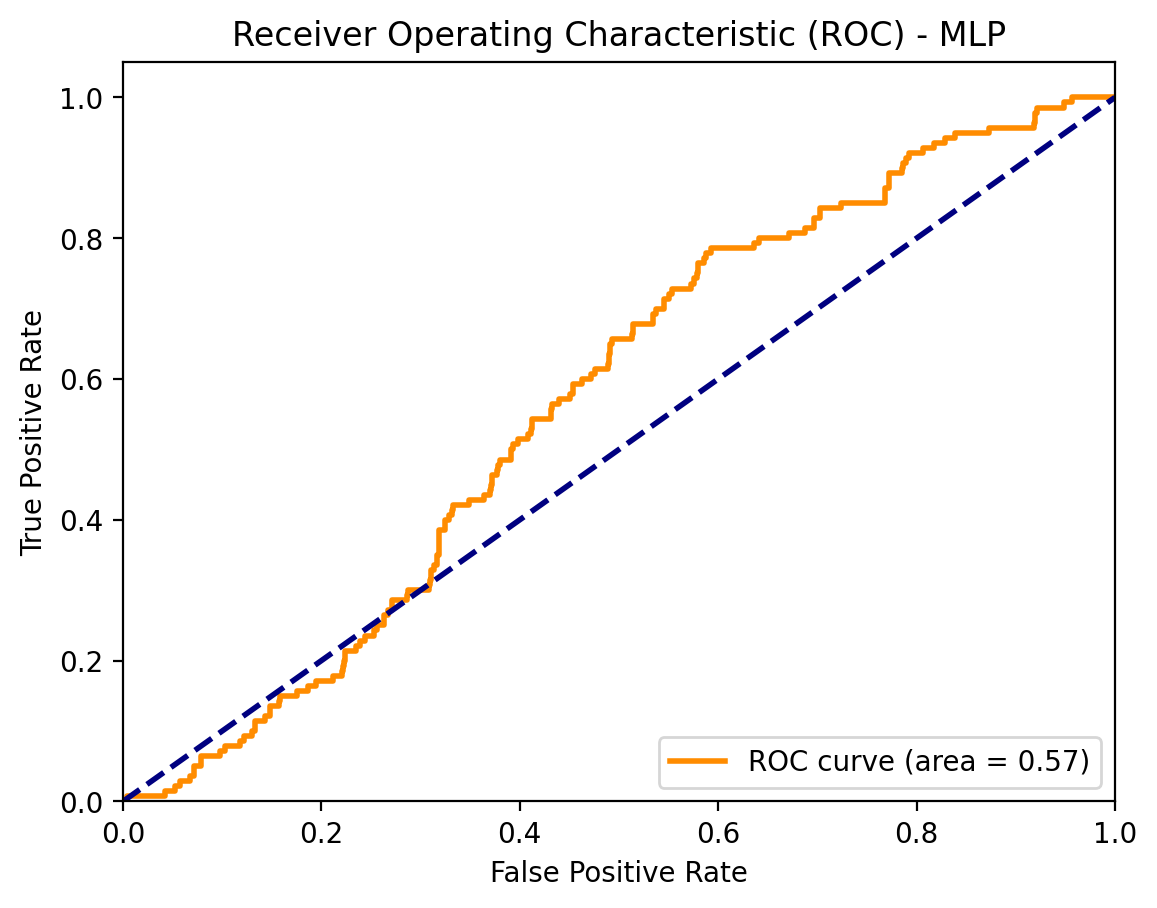

AUC ROC for MLP is 0.5697068867387592


In [28]:
from sklearn import metrics
import matplotlib.pyplot as plt
def plot_roc_curve(model, data, true_labels):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(data)
        # Apply softmax to obtain the probabilities
        probabilities = F.softmax(outputs, dim=1)[:, 0].numpy()  # Probabilities for the positive class

        true_labels = true_labels.numpy()

    # Compute ROC curve and ROC area
    fpr, tpr, _ = metrics.roc_curve(true_labels, probabilities, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - MLP')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

# Plot ROC curve and get AUC for MLP
roc_auc_mlp = plot_roc_curve(mlp_model, test_data, test_labels)
print(f"AUC ROC for MLP is {roc_auc_mlp}")
